In [1]:
import os
os.chdir("..")


In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from numerics.utilities.misc import *
import matplotlib
from scipy.linalg import solve_continuous_are
import pickle
from tqdm import tqdm
from analysis.misc import *
from scipy.special import erf

params, exp_path = def_params(flip = 0)

which = mode = give_model()
if which == "mechanical_damp":
    total_time = 4.
    dt = 1e-5
elif which == "mechanical_freq":
    omega = .5*(params[1][1] + params[0][1])
    T_param = 150.
    ppg = 1e3
    period = 2*np.pi/omega
    total_time = T_param*period
    dt = period/ppg
elif (which == "optical_homodyne") or (which == "optical_heterodyne"):
    damping = params[1][0]
    total_time = 200.*damping
    dt = damping/1e3

timind, indis, indis_range = get_timind_indis(total_time, dt, rrange=True)



In [3]:
path_data = get_def_path()+"analysis/muDIff/{}/".format(5000,mode)

In [4]:
log_lik_ratio, log_lik_ratio_swap = load_liks(itraj=1, total_time=total_time, dt=dt)

In [13]:
B = 8.
dB = .1
boundsB= np.arange(-B,B+dB,dB)
bpos = boundsB[boundsB>=0]

In [5]:
with open(path_data+"deter.pickle","rb") as f:
   deter = pickle.load(f)#, protocol=pickle.HIGHEST_PROTOCOL)

### load (just in case)
timbin1 = np.load(path_data+"timbin.npy")
timbin0 = np.load(path_data+"timbin.npy")#, timbin0)

l0 = np.load(path_data+"l0.npy")
l1 = np.load(path_data+"l1.npy")

cons0 = np.load(path_data+"cons0.npy")
cons1 = np.load(path_data+"cons1.npy")


stoch = np.load(path_data+"times_to_err_stoch.npy")
times_alpha_to_errB = np.load(path_data+"times_to_err_det.npy")

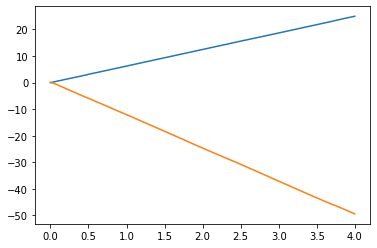

In [6]:
plt.plot(timind, l1)
plt.plot(timind, l0)

In [10]:
mu1, _ = np.polyfit(timind[:-100], l1[:-100],1)
mu0, _ = np.polyfit(timind[:-100], l0[:-100],1)

In [11]:
alpha_err = np.array([0.5*(1 - erf(0.5*np.sqrt(t*np.abs(mu0)))) for t in timind])
beta_err = np.array([0.5*(1 - erf(0.5*np.sqrt(t*abs(mu1)))) for t in timind])

In [14]:
alphas = np.stack([deter["h1/h0"][k] for k in range(len(boundsB))])
betas = np.stack([deter["h0/h1"][k] for k in range(len(boundsB))])

In [15]:
eql = np.argmin(np.abs(boundsB))

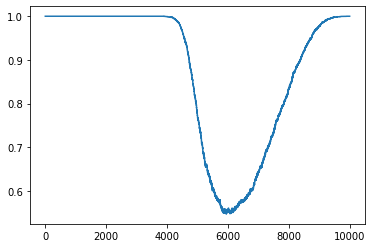

In [16]:
plt.plot(alphas[eql+1,:])

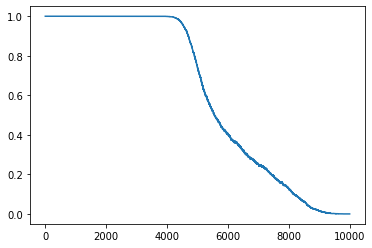

In [154]:
plt.plot(betas[eql+1,:])

Text(0.5, 0, 'Time')

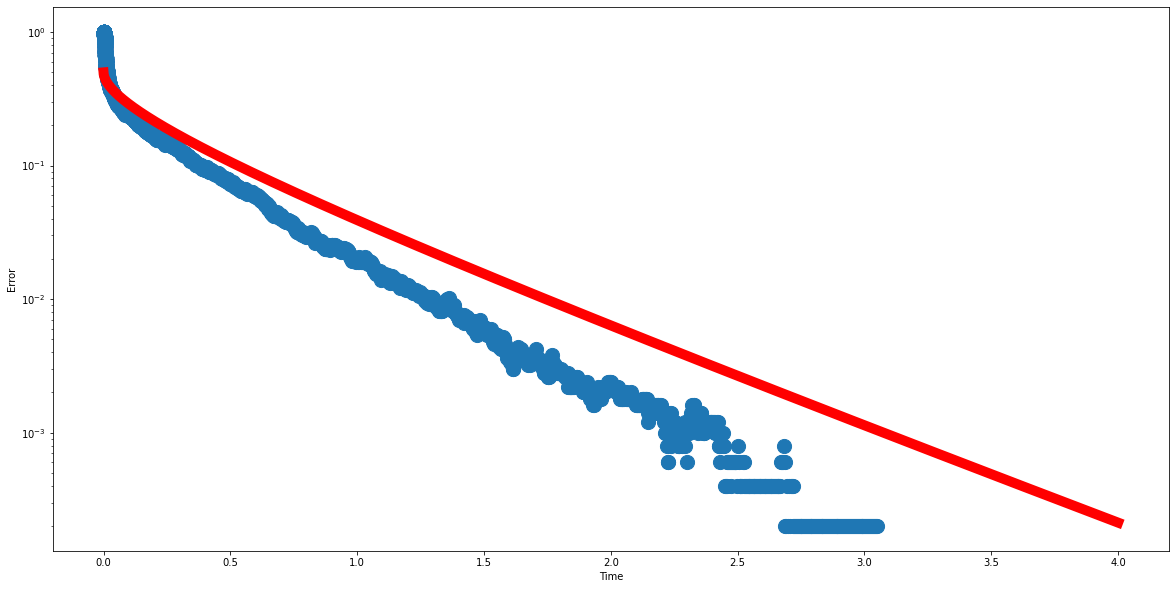

In [157]:
plt.figure(figsize=(20,10))
ax = plt.subplot(111)
ax.scatter(timind,betas[eql+1,:],s=200)
ax.plot(timind, .5*(beta_err + beta_err),color="red", linewidth=10)
ax.set_yscale("log")
ax.set_ylabel("Error")
ax.set_xlabel("Time")

/tmp/ipykernel_7230/1293339348.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  return  abs(b)*np.exp(-((abs(b)-mu*t)**2)/(2*t*(S**2)))/div
/tmp/ipykernel_7230/1293339348.py:18: RuntimeWarning: invalid value encountered in double_scalars
  return  abs(b)*np.exp(-((abs(b)-mu*t)**2)/(2*t*(S**2)))/div


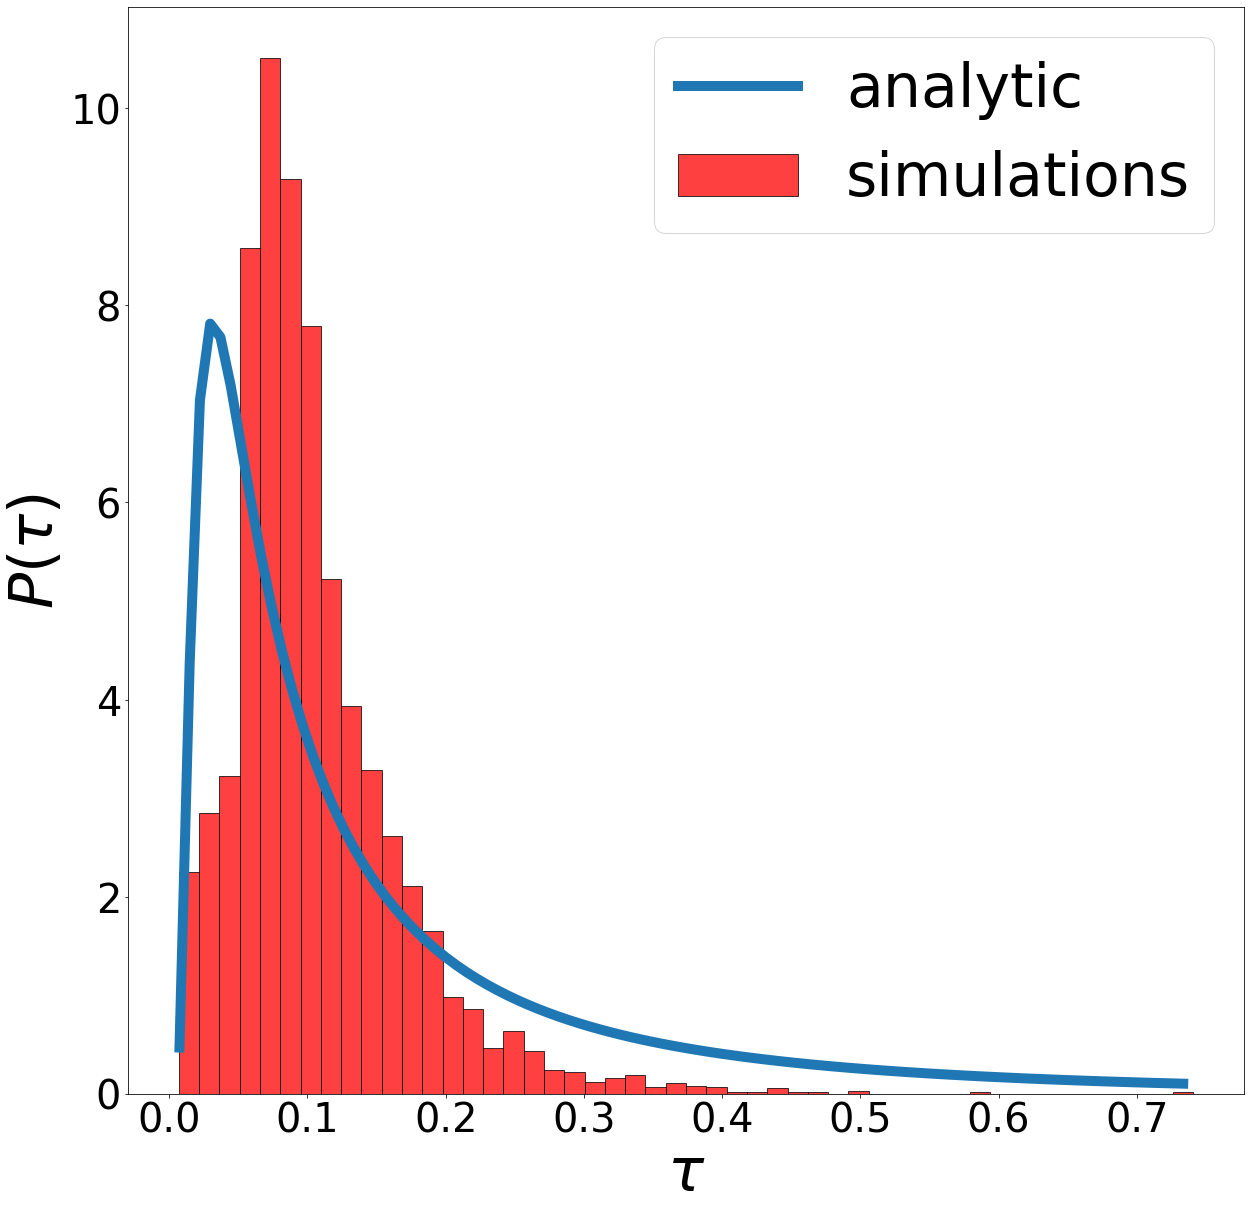

In [17]:
timbin1 = np.load(path_data+"timbin.npy")
timbin0 = np.load(path_data+"timbin.npy")#, timbin0)

l0 = np.load(path_data+"l0.npy")
l1 = np.load(path_data+"l1.npy")

cons0 = np.load(path_data+"cons0.npy")
cons1 = np.load(path_data+"cons1.npy")


stoch = np.load(path_data+"times_to_err_stoch.npy")
times_alpha_to_errB = np.load(path_data+"times_to_err_det.npy")


def prob_craft(t, b, mu):
    S= np.sqrt(2*mu)
    div = (np.sqrt(2*np.pi)*S*(t**(3/2)))
    return  abs(b)*np.exp(-((abs(b)-mu*t)**2)/(2*t*(S**2)))/div

muu, _ = np.polyfit(timind, l1,1)

LS, TS = 60, 40
plt.figure(figsize=(20,20))
ax = plt.subplot(111)
indb = 10
LW = 10
# timm =  np.linspace(np.min(timbin1[indb]),np.max(timbin1[indb]),100)
timm =  np.linspace(0,np.max(timbin1[indb]),100)
popo = [prob_craft(tt, bpos[indb] , muu) for tt in timm]
ax.plot(timm,popo, linewidth=LW, label="analytic")
ax.bar(timbin1[indb], cons1[indb], width=timbin1[indb][1]-timbin1[indb][0], color="red", alpha=0.75, edgecolor="black", label="simulations")
ax.set_xlabel(r'$\tau$',size=LS)
ax.set_ylabel(r'$P(\tau)$', size=LS)
ax.tick_params(axis='both', which='major', labelsize=TS)
ax.legend(prop={"size":LS})

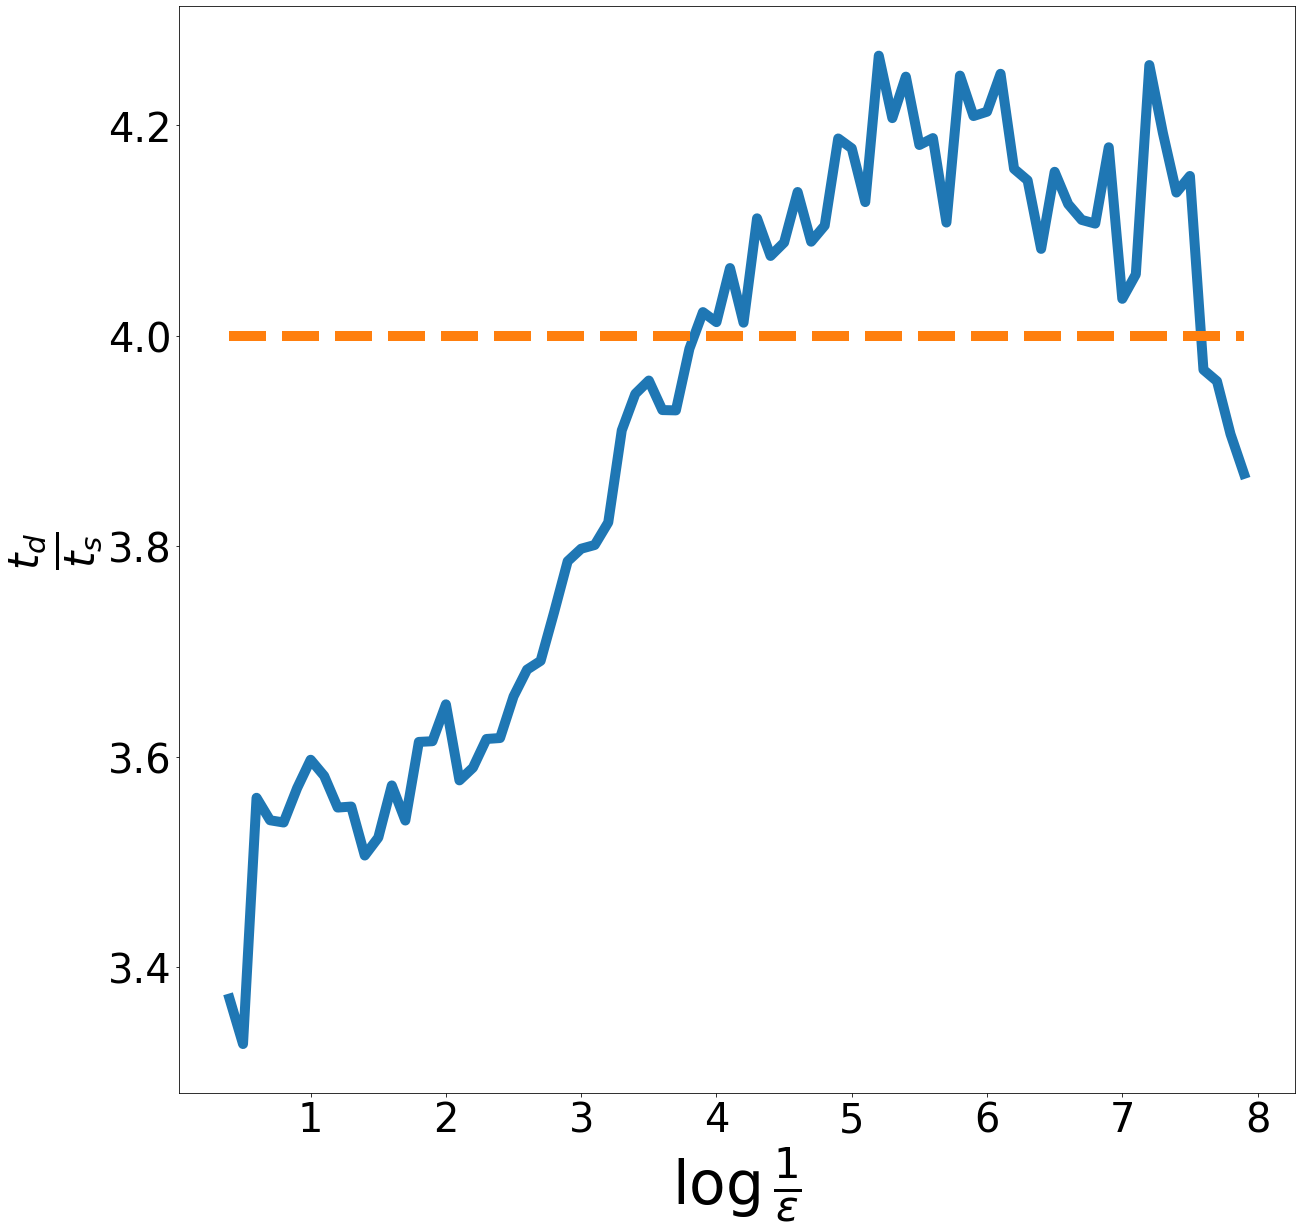

In [19]:
fig = plt.figure(figsize=(20,20))
ax = plt.subplot(111)

fromm = 3
too = -1
ax.plot(bpos[fromm:too],(times_alpha_to_errB/stoch)[fromm:too], linewidth=LW)
ax.plot(bpos[fromm:too],4*np.ones(len(stoch[fromm:too])),'--', linewidth=LW)
ax.set_xlabel(r'$\log \frac{1}{\epsilon}$', size=LS)
ax.tick_params(axis='both', which='major', labelsize=TS)
ax.set_ylabel(r'$\frac{t_d}{t_s}$', size=LS)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

In [20]:
n=1
M=int(5*1e3)
ll1 = []
ll0 = []
for itraj in tqdm(range(1,M)):
    log_lik_ratio, log_lik_ratio_swap = load_liks(itraj=itraj, total_time=total_time, dt=dt)
    ll1.append(log_lik_ratio)
    ll0.append(log_lik_ratio_swap)    
ll1 = np.stack(ll1)
ll0 = np.stack(ll0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:08<00:00, 615.47it/s]


In [23]:
os.makedirs("fig_gif", exist_ok=True)

In [33]:
def gaussian(x,mu, sig):
    return np.exp(-(x - mu)**2/(2*sig**2))/np.sqrt(2*np.pi*sig**2)

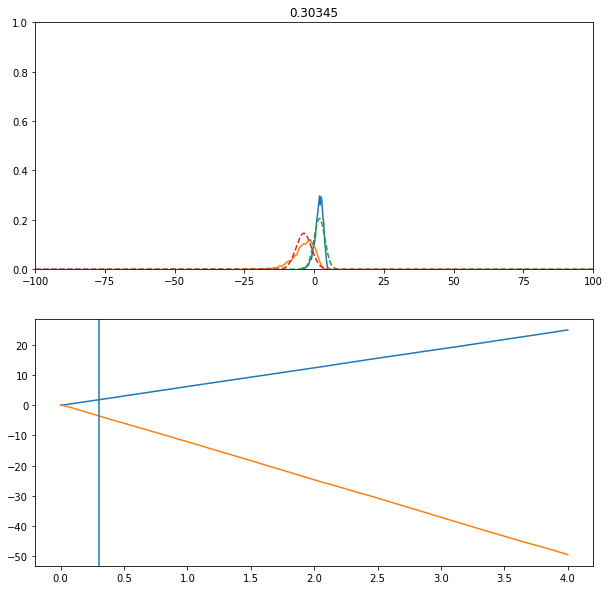

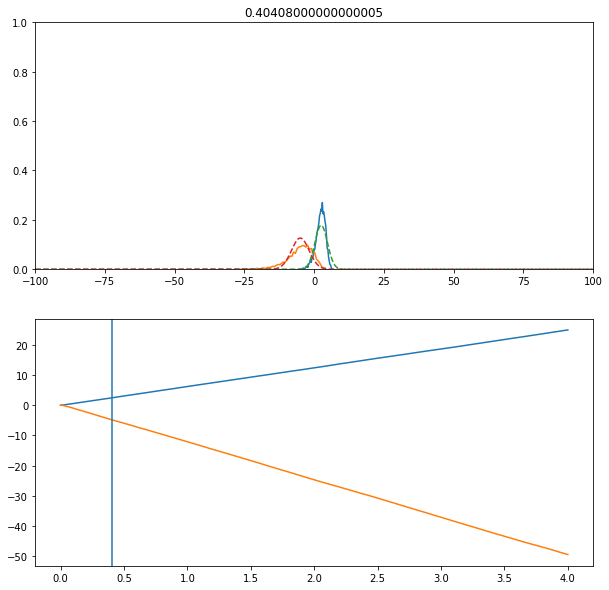

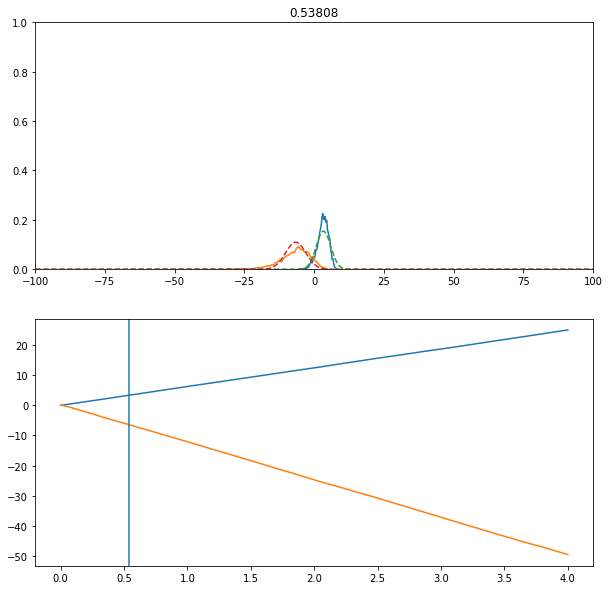

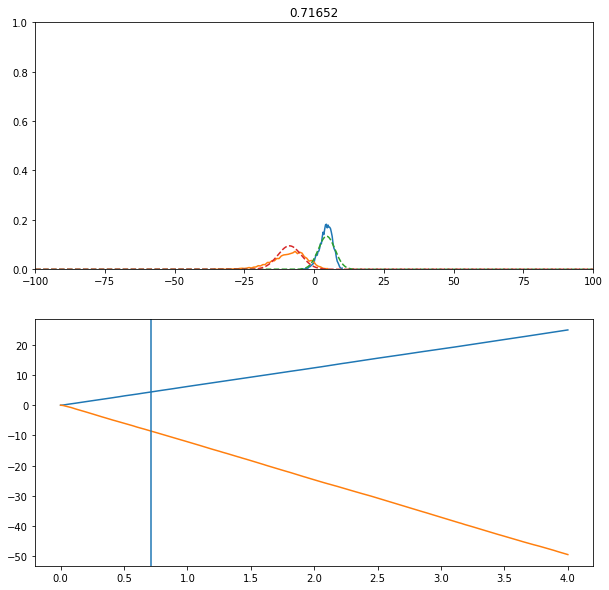

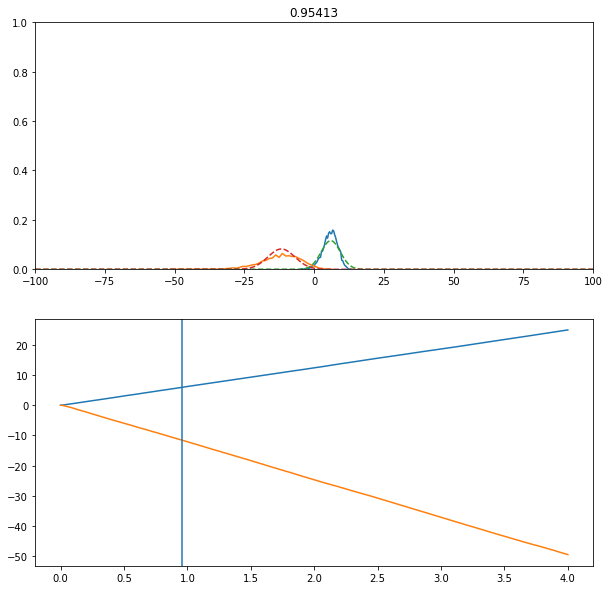

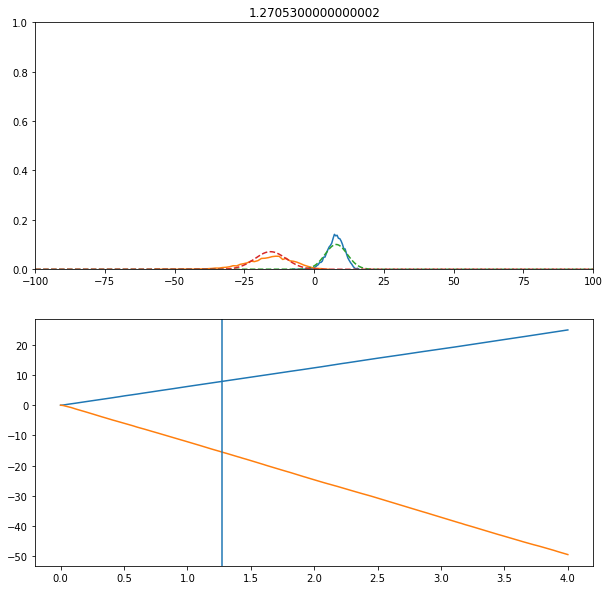

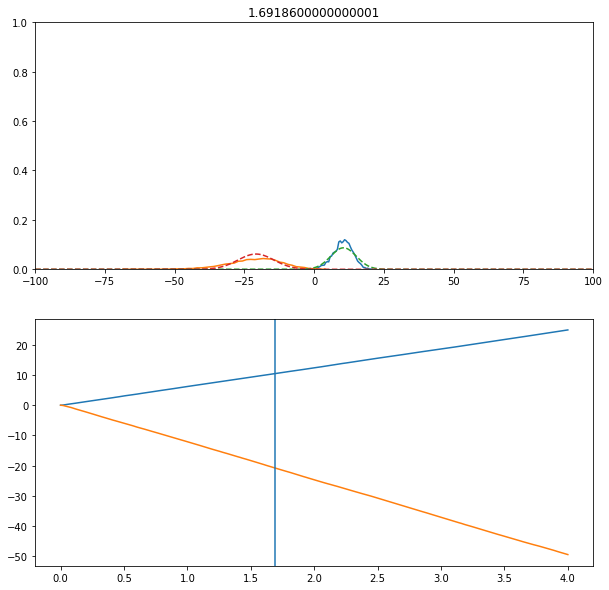

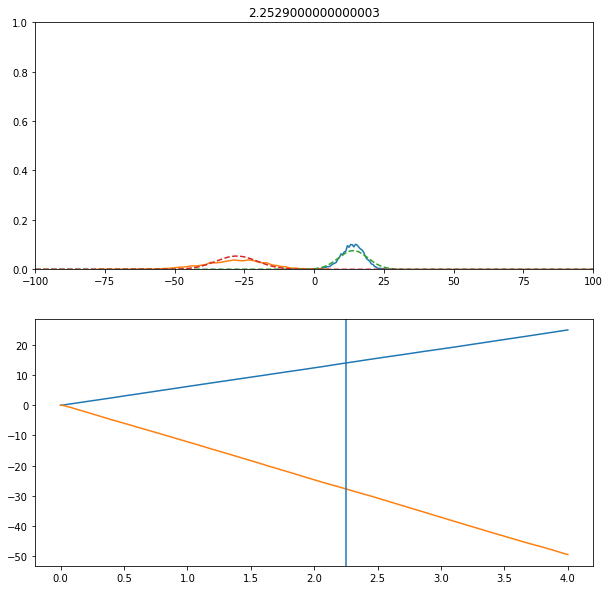

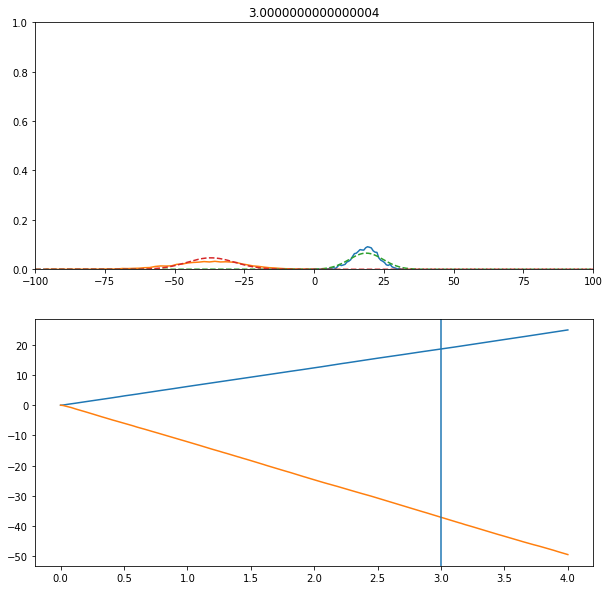

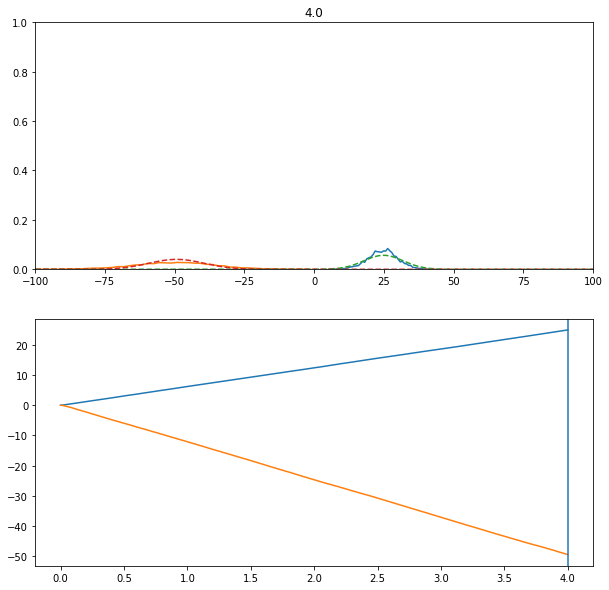

In [34]:
L=100
for ii,k in enumerate(np.linspace(8000,len(timind)-1,10)):

    c1, b1 = np.histogram(ll1[:,int(k)],bins=50, density=True)
    c0, b0 = np.histogram(ll0[:,int(k)],bins=50, density=True)

    plt.figure(figsize=(10,10))
    ax=plt.subplot(211)
    ax.set_title(timind[int(k)])
    ax.plot(b1[:-1], c1)
    ax.plot(b0[:-1], c0)
    t = timind[int(k)]
    eel = np.linspace(-L,L,int(1e4))
    dist1 = [gaussian(l, mu1*t, np.sqrt(2*mu1*t)) for l in eel]
    dist0 = [gaussian(l, mu0*t, np.sqrt(2*abs(mu0*t))) for l in eel]
    ax.plot(eel, dist1,'--')
    ax.plot(eel, dist0,'--')
    ax.set_xlim([-L,L])
    ax.set_ylim([0,1])    
    ax=plt.subplot(212)
    ax.plot(timind, l1)
    ax.plot(timind, l0)
    ax.axvline(timind[int(k)])
    
    plt.savefig("fig_gif/{}.png".format(ii))

# States

In [35]:
path = get_path_config(total_time = 4., dt= 1e-5, itraj=itraj, exp_path=exp_path)


In [36]:
states1 = load_data(exp_path=exp_path, itraj=1, total_time=4. , dt=dt, what="states1.npy")
states2 = load_data(exp_path=exp_path, itraj=1, total_time=4. , dt=dt, what="states1.npy")

In [ ]:
load_states(itraj, mode="damping",dtt=1e-5, to)

In [37]:
n=1
M=int(5*1e3)
ss1 = []
ss0 = []
for itraj in tqdm(range(1,M)):
    states1 = load_data(exp_path=exp_path, itraj=itraj, total_time=4. , dt=dt, what="states1.npy")
    states0 = load_data(exp_path=exp_path, itraj=itraj, total_time=4. , dt=dt, what="states0.npy")
    ss1.append(states1)
    ss0.append(states0)
    
ss1 = np.stack(ss1)
ss0 = np.stack(ss0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:06<00:00, 732.93it/s]


In [43]:
[gamma1, omega1, n1, eta1, kappa1],[gamma0, omega0, n0, eta0, kappa0],   = params

In [75]:
np.sqrt(kappa1*eta1)*dt

0.001

Text(0.5, 1.0, 'h1 true')

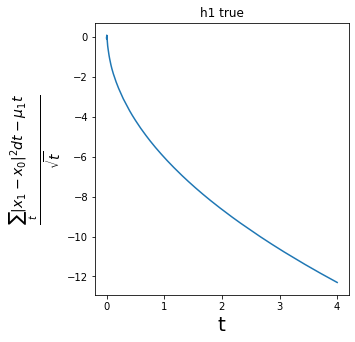

In [136]:
plt.figure(figsize=(10,5))
ax = plt.subplot(121)
ax.plot(timind,(np.cumsum(0.5*4*kappa1*eta1*np.sum((np.abs(ss1[200] - ss0[200]))**2,axis=1))*dt - mu1*np.array(timind))/np.sqrt(timind))
ax.set_ylabel(r'$\frac{\sum_t |x_1 - x_0|^2 dt  -\mu_1 t}{\sqrt{t}}$',size=20)
ax.set_xlabel("t",size=20)
ax.set_title("h1 true")

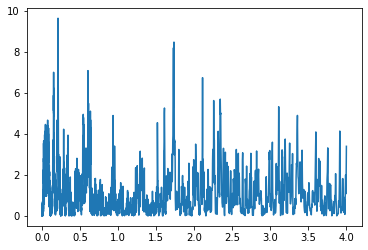

In [137]:
plt.plot(timind,0.5*4*kappa1*eta1*np.sum((np.abs(ss1[20] - ss0[20]))**2,axis=1)/mu1)

In [138]:
diff = ss1 - ss0
C = np.sqrt(4*eta1*kappa1)

In [140]:
dsq = np.einsum('std, std -> st',np.dot(C,diff),np.dot(C,diff))
dst = 0.5*np.mean(dsq,axis=0)

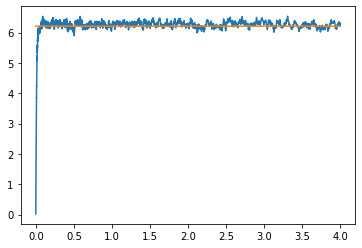

In [142]:
plt.plot(timind,dst)
plt.plot(timind, mu1*np.ones(len(timind)))
